In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from tqdm import tqdm

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
api = wandb.Api()
runs = api.runs("orientino/adam-sgd-gap")

summary = []
for run in tqdm(runs):
    if run.tags:
        continue
    if run.config.get("n_layers") != 6:
        continue

    entry = {}
    entry["data"] = run.config.get("data")
    entry["lr"] = run.config.get("lr")
    entry["bs"] = run.config.get("bs")
    entry["mom"] = run.config.get("mom")
    entry["opt"] = run.config.get("opt")

    history = run.history(keys=["train/loss"], samples=80000)
    entry["tr_loss_history"] = history["train/loss"].tolist()
    entry["tr_loss"] = run.summary.get("train/loss")
    entry["vl_acc"] = run.summary.get("val/acc1")
    summary.append(entry)

len(summary)

100%|██████████| 1058/1058 [03:45<00:00,  4.70it/s] 


336

In [37]:
# df = pd.DataFrame(summary)
# df.to_csv("_results/gap_vision_over_under.csv", index=False)

In [3]:
print(len(summary[0]["tr_loss_history"]))
grouped = (
    pd.DataFrame(summary)
    .groupby(["data", "opt", "mom"])
    .size()
    .reset_index(name="count")
)
print(grouped)

10000
   data   opt    mom  count
0   c10  adam  0.900     21
1   c10  adam  0.950     21
2   c10  adam  0.990     21
3   c10  adam  0.999     21
4   c10   sgd  0.900     21
5   c10   sgd  0.950     21
6   c10   sgd  0.990     21
7   c10   sgd  0.999     21
8   c5m  adam  0.900     21
9   c5m  adam  0.950     21
10  c5m  adam  0.990     21
11  c5m  adam  0.999     21
12  c5m   sgd  0.900     21
13  c5m   sgd  0.950     21
14  c5m   sgd  0.990     21
15  c5m   sgd  0.999     21


/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_15772/3364183906.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("GnBu_r", len(bss) + 4)
/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_15772/3364183906.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd_r", len(bss) + 4)


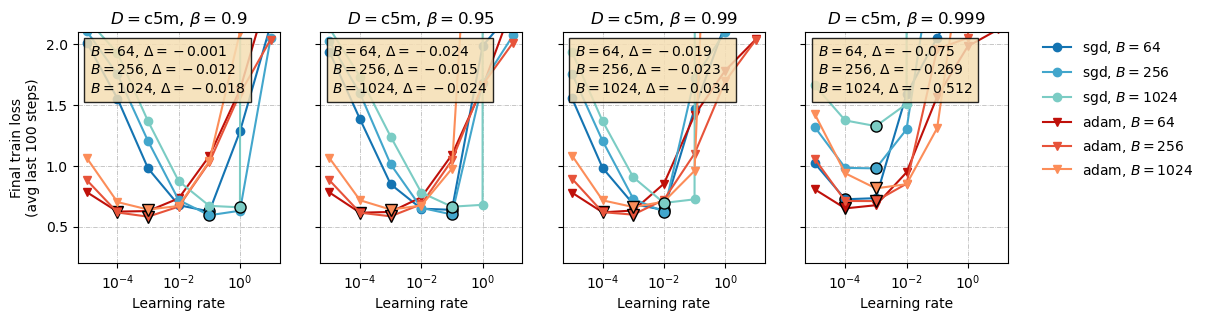

In [17]:
data = "c10"
data = "c5m"
metric = "tr_loss_avg"
window = 100
bss = [64, 256, 1024]

metric2text = {
    "tr_loss_min": f"Final train loss\n(min last {window} steps)",
    "tr_loss_avg": f"Final train loss\n(avg last {window} steps)",
    "tr_loss": "Final train loss",
    "vl_acc": "Final val acc",
}

df = pd.DataFrame(summary)
df = df[df["data"] == data]
df["tr_loss_min"] = df["tr_loss_history"].apply(lambda x: np.min(x[-window:]))
df["tr_loss_avg"] = df["tr_loss_history"].apply(lambda x: np.mean(x[-window:]))
beta_unique = sorted(df["mom"].dropna().unique())
beta_n = len(beta_unique)

fig, axes = plt.subplots(1, beta_n, figsize=(3.0 * beta_n, 3.0), sharey=True)
markers = ["o", "v", "D", "X", "^", "s", "p"]

colors = []
cmap = plt.cm.get_cmap("GnBu_r", len(bss) + 4)
colors.append([cmap(i + 1) for i in range(len(bss))])
cmap = plt.cm.get_cmap("OrRd_r", len(bss) + 4)
colors.append([cmap(i + 1) for i in range(len(bss))])

for i, beta in enumerate(beta_unique):
    deltas = []
    for j, bs in enumerate(bss):
        subset = df[df["mom"] == beta]
        subset = subset[subset["bs"] == bs]
        sgd = subset[subset["opt"] == "sgd"].sort_values("lr")
        adam = subset[subset["opt"] == "adam"].sort_values("lr")

        axes[i].plot(
            sgd["lr"],
            sgd[metric],
            color=colors[0][j],
            marker=markers[0],
            label=f"sgd, $B={bs}$",
        )
        axes[i].plot(
            adam["lr"],
            adam[metric],
            color=colors[1][j],
            marker=markers[1],
            label=f"adam, $B={bs}$",
        )

        # outline the minimum marker
        x_min_sgd = (sgd.loc[sgd[metric].idxmin(), "lr"],)
        y_min_sgd = (sgd.loc[sgd[metric].idxmin(), metric],)
        axes[i].plot(
            x_min_sgd,
            y_min_sgd,
            marker=markers[0],
            color=colors[0][j],
            markeredgecolor="black",
            markersize=8,
        )
        x_min_adam = (adam.loc[adam[metric].idxmin(), "lr"],)
        y_min_adam = (adam.loc[adam[metric].idxmin(), metric],)
        axes[i].plot(
            x_min_adam,
            y_min_adam,
            marker=markers[1],
            color=colors[1][j],
            markeredgecolor="black",
            markersize=8,
        )
        delta = y_min_adam[0] - y_min_sgd[0]
        deltas.append(delta)
    delta_text = f"$B={bss[0]}$, $\\Delta={deltas[0]:+.3f}$\n"
    delta_text += f"$B={bss[1]}$, $\\Delta={deltas[1]:+.3f}$\n"
    delta_text += f"$B={bss[2]}$, $\\Delta={deltas[2]:+.3f}$"
    axes[i].text(
        0.06,
        0.95,
        delta_text,
        transform=axes[i].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="wheat", alpha=0.85),
    )

    axes[i].set_title(f"$D=${data}, $\\beta={beta}$")
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Learning rate")
    axes[i].grid(True, ls="-.", lw=0.5)
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    if "min" in metric:
        axes[i].set_ylim(-0.1, 1.8)
    elif "avg" in metric:
        axes[i].set_ylim(0.2, 2.1)
axes[0].set_ylabel(metric2text[metric])

# reorder labels so that sgd are on top and adam at the bottom
handles, labels = axes[0].get_legend_handles_labels()
sgd_handles = [h for h, l in zip(handles, labels) if l.startswith("sgd")]
sgd_labels = [l for l in labels if l.startswith("sgd")]
adam_handles = [h for h, l in zip(handles, labels) if l.startswith("adam")]
adam_labels = [l for l in labels if l.startswith("adam")]
fig.legend(
    sgd_handles + adam_handles,
    sgd_labels + adam_labels,
    loc="upper right",
    bbox_to_anchor=(1.065, 0.9),
    frameon=False,
)
plt.savefig(
    f"_figures/gap_{data}_{metric}.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight",
)

/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_15772/3366672.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("GnBu_r", len(bss) + 4)
/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_15772/3366672.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd_r", len(bss) + 4)


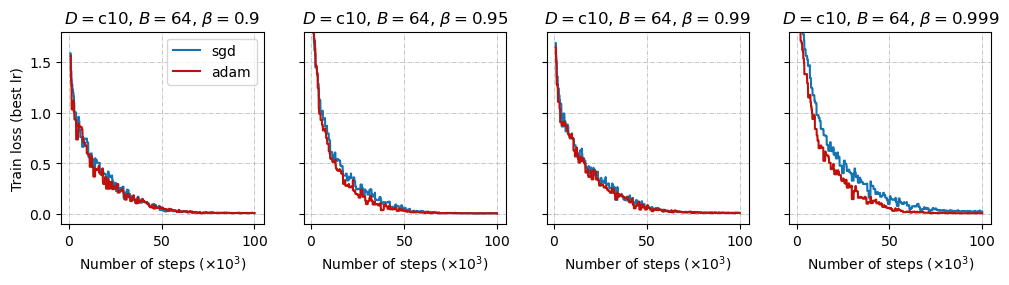

In [24]:
def smooth_min(y, window=10):
    return pd.Series(y).rolling(window).min().values


bs = 64
data = "c10"
window = 100

df = pd.DataFrame(summary)
df = df[df["data"] == data]
df = df[df["bs"] == bs]
beta_unique = sorted(df["mom"].dropna().unique())
beta_n = len(beta_unique)

fig, axes = plt.subplots(1, beta_n, figsize=(3.0 * beta_n, 2.5), sharey=True)
colors = []
cmap = plt.cm.get_cmap("GnBu_r", len(bss) + 4)
colors.append([cmap(i + 1) for i in range(len(bss))])
cmap = plt.cm.get_cmap("OrRd_r", len(bss) + 4)
colors.append([cmap(i + 1) for i in range(len(bss))])

for i, beta in enumerate(beta_unique):
    subset = df[df["mom"] == beta]

    for j, opt in enumerate(["sgd", "adam"]):
        opt_subset = subset[subset["opt"] == opt].nsmallest(1, "tr_loss")
        histories = opt_subset["tr_loss_history"].tolist()
        min_len = min(len(h) for h in histories)
        histories = [h[:min_len] for h in histories]
        avg_history = smooth_min(np.mean(histories, axis=0), window)
        steps = np.arange(len(avg_history)) * 10

        axes[i].plot(steps, avg_history, label=opt, color=colors[j][0])

    axes[i].set_title(f"$D=${data}, $B={bs}$, $\\beta={beta}$")
    axes[i].set_xlabel(r"Number of steps ($\times 10^3$)")
    axes[i].grid(True, ls="-.", lw=0.5)
    axes[i].set_ylim(-0.1, 1.8)
    axes[i].set_xticks([0, 50_000, 100_000])
    axes[i].set_xticklabels([r"$0$", r"$50$", r"$100$"])

axes[0].set_ylabel("Train loss (best lr)")
axes[0].legend()